# Data Science Project 01 - Inheritance of beak morphology in the Galapagos finches 
---
_This project was developed as part of the Data Science Certification provided by DataCamp_.
Dec 2020.

#### José Oliveira da Cruz, Dec 2020.


___Disclaimer___: The information about the dataset was provided by DataCamp and my role as student was to code the entire analysis and draw additional conclusions. Initial guidelines were provided by the instructor [Justin Bois](https://bois.caltech.edu/).

## Introduction
---
### The objective of the project is to apply statistical inference uncover evolution of beak morphology. 

Many of the important observations that led Charles Darwin to develop the theory of evolution were made in the Galápagos archipelago, particularly in the study of the small birds, called finches, that inhabit them. The islands are ideal for studying evolution because they are isolated so they do not have complicated effects from interactions with other species including humans. Furthermore, some of them are small, so entire populations can be monitored on a given island. Every year since 1973, Peter and Rosemary Grant of Princeton University have been spending several months of the year on the tiny volcanic cinder cone island of Daphne Major in the Galápagos.

This island has two dominant ground finch species, _Geospiza fortis_ and _Geospiza scandens_. The Grants have monitored them every year, tagging them, making physiological measurements, taking samples for genetic sequencing, and more. In 2014, they published a book entitled "40 Years of Evolution: Darwin's Finches on Daphne Major Island". 

In [1]:
# Import Necessary Packages
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## The dataset
---

Peter and Rosemary Grant measured during the past 40 years the beak morphology for 2 species of finch birds ( _Geospiza fortis_ and _Geospiza scandens_) present in the the Galápagos island of Daphne Major.

The subset of the original dataset used in this notebook was curated and made avaiable by DataCamp staff as part of this project.

In [2]:
# upload the dataset
link_finch_1975 = 'https://assets.datacamp.com/production/repositories/470/datasets/eb228490f7d823bfa6458b93db075ca5ccd3ec3d/finch_beaks_1975.csv'
finch_1975 = pd.read_csv(link_finch_1975)
finch_1975['year'] = 1975

link_finch_2012 = 'https://assets.datacamp.com/production/repositories/470/datasets/b28d5bf65e38460dca7b3c5c0e4d53bdfc1eb905/finch_beaks_2012.csv'
finch_2012 = pd.read_csv(link_finch_2012)
finch_2012['year'] = 2012

# get the same column names
finch_1975.columns = finch_2012.columns

# Merge the 2 datasets together
finch_main = finch_1975.append(finch_2012, ignore_index=True)

In [3]:
finch_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   band     651 non-null    int64  
 1   species  651 non-null    object 
 2   blength  651 non-null    float64
 3   bdepth   651 non-null    float64
 4   year     651 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 25.6+ KB


The dataset contains the following information:  

|Column|Obs|
|---|---|
|band|Individual identification|
|species |Species ID|
|blength | Beak Length in mm|
|bdepth | Beak Depth in mm|
|year|Year of Measurement|

In [4]:
finch_main.head()

,band,species,blength,bdepth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975


## PART 1 - Exploratory Data Analysis
___


Peter and Rosemary Grant reported that changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. 

The first objective it to understand how the beak morphology (depth and length) of _Geospiza scandens_ changed over time.

In [5]:
# The dataset contains 2 species of Geospiza
finch_main.species.unique()

array(['fortis', 'scandens'], dtype=object)

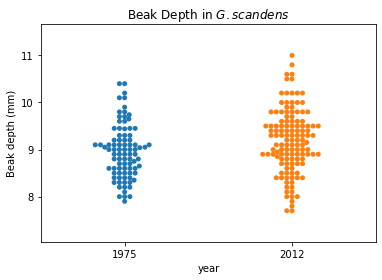

In [6]:
fig, ax = plt.subplots()
sns.swarmplot(
    x='year',
    y='bdepth',
    data=finch_main[finch_main.species.isin(['scandens'])],
    ax=ax,
)
ax.set(ylabel='Beak depth (mm)', title="Beak Depth in $\it{G. scandens}$")
ax.margins(0.2)

By using simple swarmplots it is not clear whether there are changes in beak depth over the last 40 years. Let's look at the distributions instead.

In [7]:
def ecdf(
        data,
):
    """Returns x, y to plot an Empirical Cumulative Distribution Function.

    Parameters
    ----------
    data : Sequence of int or floats
        List of values to sort.

    Returns
    -------
    x : np.array
        Sorted numpy array with data.
    y : np.array
        Percentiles.

    """
    # sort data
    x = np.sort(data)

    # create linear space between 0 and 1.
    y = np.linspace(0, 1, len(data))
    
    return x, y


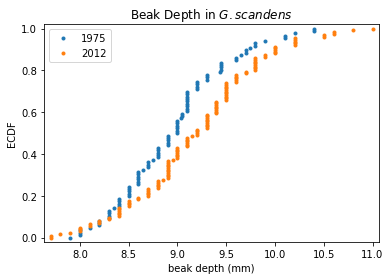

In [8]:
# Prepare data for ECDF
x_1915, y_1975 = ecdf(finch_1975.bdepth[finch_1975.species.isin(['scandens'])])
x_2012, y_2012 = ecdf(finch_2012.bdepth[finch_2012.species.isin(['scandens'])])

fig, ax = plt.subplots()

ax.plot(x_1915, y_1975, label='1975', marker='.', ls='none')
ax.plot(x_2012, y_2012, label='2012', marker='.', ls='none')

ax.set(ylabel='ECDF', xlabel='beak depth (mm)', title="Beak Depth in $\it{G. scandens}$")
ax.margins(0.02)
ax.legend();

It seems that the depth of the beak depth has increased over time but how confident are we about this measurements?  

Let's use bootstring calculate the 95% confidence interval on the mean change in beak depth.

In [9]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates.

    Parameters
    ----------
    data : sequence of int/floats

    func : funct
        The test statistic to be used.

    size : opt, int
        The number of replicates to be drawn.

    returns
    bs_replicates : np.array
        Array with bootstrap replicates.
    """

    # Instantiate array to hold the results
    bs_replicates = np.empty(size)

    # iterate size times
    for i in range(size):

        # Get a new sample with replacement
        bs_sample = np.random.choice(data, size=len(data))

        # Perform a test statistic and add data to the bs_replicates array
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

In [10]:
# Extract the data
bd_scandens_1975 = finch_1975.bdepth[finch_1975.species.isin(['scandens'])]
bd_scandens_2012 = finch_2012.bdepth[finch_2012.species.isin(['scandens'])]

# Calculate the original beak mean difference
diff_means = bd_scandens_2012.mean() - bd_scandens_1975.mean()

In [11]:
# Draw replicates for each population
bs_replicates_1975 = draw_bs_reps(bd_scandens_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_scandens_2012, np.mean, size=10000)

# perform element-wise mean diff
bs_diff_means = bs_replicates_2012 - bs_replicates_1975

# Get the 95% confidence interval
ci95 = np.percentile(bs_diff_means, [2.5, 97.5])

# Print the results
print(f'The original difference of means = {diff_means} mm')
print(f'95% confidence interval = {ci95} mm')

The original difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06096452 0.38898364] mm


Let's plot the histogram to have a picture of the bootstraping process.

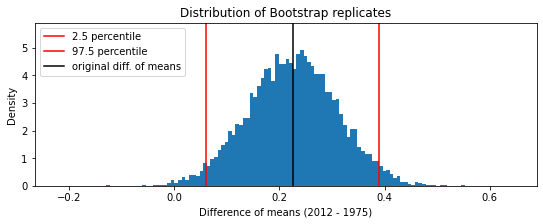

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(bs_diff_means, bins=100, density=True);
ax.axvline(ci95[0], color='red', label='2.5 percentile')
ax.axvline(ci95[1], color='red', label='97.5 percentile')
ax.axvline(diff_means, color='black', label='original diff. of means')

ax.set(
    ylabel='Density',
    xlabel='Difference of means (2012 - 1975)',
    title='Distribution of Bootstrap replicates'
)
ax.legend(loc='upper left')
ax.margins(0.2)

It seems that indeed the beaks of _G. scandens_ have gotten deeper. But how likely is this conclusion to be true?

We can use hypothesis testing to address this question. We will ask the following question:

- What is the probability that we would get the observed difference in mean beak depth **if the means were the same**? 

__To test this hypothesis we can use bootstrapping with replacement.__

If our questions was about whether the birds come from the same distribution, we could use a permutation test. 

In [13]:
# Calculate original difference in means
original_diff_means = bd_scandens_2012.mean() - bd_scandens_1975.mean()

# Merge the populations
bd_scandens_merged = np.concatenate((bd_scandens_1975, bd_scandens_2012))

# Shift data to center around the full mean with variance unchanged
shifted_bd_scandens_1975 = bd_scandens_1975 - bd_scandens_1975.mean()\
                           + bd_scandens_merged.mean()

shifted_bd_scandens_2012 = bd_scandens_2012 - bd_scandens_2012.mean()\
                           + bd_scandens_merged.mean()

# Create new replicates
bs_replicates_scandens_1975 = draw_bs_reps(shifted_bd_scandens_1975,
                                           np.mean,
                                           size=10000)

bs_replicates_scandens_2012 = draw_bs_reps(shifted_bd_scandens_2012,
                                           np.mean,
                                           size=10000)

# Check the difference in means
bs_replicates_diff_means = bs_replicates_scandens_2012 - bs_replicates_scandens_1975


# Calculate the probability of observing our original results if the means were the same
pvalue = np.sum(bs_replicates_diff_means >= original_diff_means)/10000

Let's plot the histogram obtained from our bootstrap simulation.

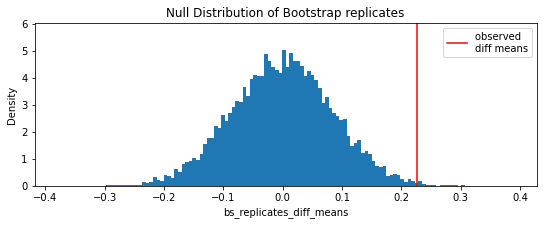

In [14]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(bs_replicates_diff_means, bins=100, density=True)

ax.axvline(original_diff_means, color='red', label='observed \ndiff means')

ax.set(
    ylabel='Density',
    xlabel='bs_replicates_diff_means',
    title='Null Distribution of Bootstrap replicates'
)

ax.legend()
ax.margins(0.2)

In [15]:
print(f"The probability of observing our results if the difference of means was the same is {pvalue}.")

The probability of observing our results if the difference of means was the same is 0.0033.


### Conclusion of Part 1
---

There is a statistically significante difference, thus strongly suggesting that beak depth is increasing over time. Specifically, we can observe that there was a 0.2 mm increase over a period of 37 years.

## PART 2 - Variation in beak shapes in _G. scandens_
---

Now that we know that there is an increase of beak depth over a time period of 37 years, let's have a look at how the overall shape is changing. 

In [16]:
scandens = finch_main[finch_main.species.isin(['scandens'])]

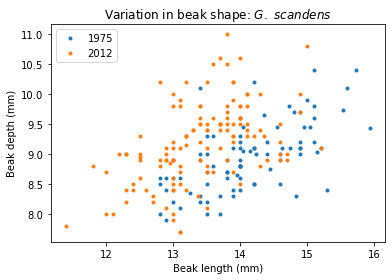

In [17]:
fig, ax = plt.subplots()

ax.plot(scandens[scandens.year==1975].blength,
        scandens[scandens.year==1975].bdepth, '.', label='1975')

ax.plot(scandens[scandens.year==2012].blength,
        scandens[scandens.year==2012].bdepth, '.', label='2012')

ax.set(
    ylabel='Beak depth (mm)',
    xlabel='Beak length (mm)',
    title='Variation in beak shape: $\itG.\ scandens$'
)

ax.legend(loc='upper left')

It seems that longer beak are associated with shorter depths. Interestingly, it seems that in 2012 this ratio is changed. It is possible to observe that the distribution if shifted to the up left corner meaning that birds beak is deeper and maybe shorter and thus it seems that the shape has changed.  

Let's investigate further is hint. First, we will model the relation of the beak depth and length with a linear model.

In [18]:
# extract the data
x_1975 = scandens[scandens.year == 1975].blength
y_1975 = scandens[scandens.year == 1975].bdepth
 
x_2012 = scandens[scandens.year == 2012].blength
y_2012 = scandens[scandens.year == 2012].bdepth

# instantiate and fit the model
coef_1975, intercept_1975 = np.polyfit(x_1975, y_1975, 1)
coef_2012, intercept_2012 = np.polyfit(x_2012, y_2012, 1)


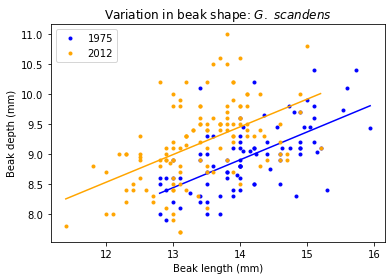

In [19]:
fig, ax = plt.subplots()

# Plot Data
ax.plot(scandens[scandens.year==1975].blength,
        scandens[scandens.year==1975].bdepth, '.', label='1975', color='blue')

# Plot Regression if 1975 data
x = [x_1975.min(), x_1975.max()]
y = np.polyval((coef_1975, intercept_1975), x)
ax.plot(x, y, '-', color='blue')

# Plot 2012 Data
ax.plot(scandens[scandens.year==2012].blength,
        scandens[scandens.year==2012].bdepth, '.', label='2012', color='orange')

# Plot Regression of 2012 data
x = [x_2012.min(), x_2012.max()]
y = np.polyval((coef_2012, intercept_2012), x)
ax.plot(x, y, '-', color='orange')

ax.set(
    ylabel='Beak depth (mm)',
    xlabel='Beak length (mm)',
    title='Variation in beak shape: $\itG.\ scandens$'
)

ax.legend(loc='upper left');

It seems tha a linear regression can capture the relation between beak depth and length for both 1975 and 2012 data. What is the confidence around the coefficients?

__Bootstrap simulation around the coefficients of the linear regression to find the 95% confidence intervals.__

In [20]:
# Extract the data
x_1975 = scandens[scandens.year == 1975].blength.to_numpy()
y_1975 = scandens[scandens.year == 1975].bdepth.to_numpy()

x_2012 = scandens[scandens.year == 2012].blength.to_numpy()
y_2012 = scandens[scandens.year == 2012].bdepth.to_numpy()

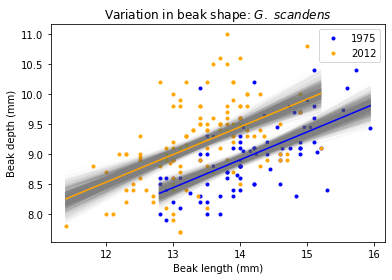

In [21]:
# Let's boot strap and build confidence intervals
fig, ax = plt.subplots()

# Plot Data
ax.plot(scandens[scandens.year==1975].blength,
        scandens[scandens.year==1975].bdepth, '.', label='1975', color='blue')


# Plot 2012 Data
ax.plot(scandens[scandens.year==2012].blength,
        scandens[scandens.year==2012].bdepth, '.', label='2012', color='orange')


size = 1000

index_array_1975 = np.arange(len(x_1975))
index_array_2012 = np.arange(len(x_2012))

bs_replicates_coef_1975 = np.empty(size)
bs_replicates_intercept_1975 = np.empty(size)
bs_replicates_coef_2012 = np.empty(size)
bs_replicates_intercept_2012 = np.empty(size)


for i in range(size):
    
    # boot strap indices
    idx_1975 = np.random.choice(index_array_1975, size=len(x_1975))
    idx_2012 = np.random.choice(index_array_2012, size=len(x_2012))
    
    # instantiate and fit the model
    bs_x_1975 = x_1975[idx_1975]
    bs_y_1975 = y_1975[idx_1975]

    bs_x_2012 = x_2012[idx_2012]
    bs_y_2012 = y_2012[idx_2012]
    
    # find coefs
    bs_coef_1975, bs_intercept_1975 = np.polyfit(bs_x_1975, bs_y_1975, 1)
    bs_coef_2012, bs_intercept_2012 = np.polyfit(bs_x_2012, bs_y_2012, 1)
    
    # Append the coefs to bs_replicates_coeff and intercept
    bs_replicates_coef_1975[i], bs_replicates_intercept_1975[i] = bs_coef_1975, bs_intercept_1975
    bs_replicates_coef_2012[i], bs_replicates_intercept_2012[i] = bs_coef_2012, bs_intercept_2012

    # Plot Regression
    x = [x_1975.min(), x_1975.max()]
    y = np.polyval((bs_coef_1975, bs_intercept_1975), x)
    ax.plot(x, y, '-', color='grey', alpha=0.02)

    # Plot Regression
    x = [x_2012.min(), x_2012.max()]
    y = np.polyval((bs_coef_2012, bs_intercept_2012), x)
    ax.plot(x, y, '-', color='grey', alpha=0.02)

    
# Plot Regression
x = [x_2012.min(), x_2012.max()]
y = np.polyval((coef_2012, intercept_2012), x)
ax.plot(x, y, '-', color='orange')
    
# Plot Regression
x = [x_1975.min(), x_1975.max()]
y = np.polyval((coef_1975, intercept_1975), x)
ax.plot(x, y, '-', color='blue')    
    
ax.set(
    ylabel='Beak depth (mm)',
    xlabel='Beak length (mm)',
    title='Variation in beak shape: $\itG.\ scandens$'
)

ax.legend();

In [22]:
# Calculate the 95%CI around the slope and intercept
coef_conf_int_1975 = np.percentile(bs_replicates_coef_1975, [2.5, 97.5])
coef_conf_int_2012 = np.percentile(bs_replicates_coef_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_replicates_intercept_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_replicates_intercept_2012, [2.5, 97.5])

print('1975: slope =', coef_1975,
      '95% confidence interval =', coef_conf_int_1975)
print('1975: intercept =', intercept_1975,
      '95% confidence interval =', intercept_conf_int_1975)
print('2012: slope =', coef_2012,
      '95% confidence interval =', coef_conf_int_2012)
print('2012: intercept =', intercept_2012,
      '95% confidence interval =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 95% confidence interval = [0.33985406 0.58651249]
1975: intercept = 2.3908752365842263 95% confidence interval = [0.69884163 4.16062188]
2012: slope = 0.462630358835313 95% confidence interval = [0.33711123 0.60974767]
2012: intercept = 2.9772474982360198 95% confidence interval = [1.00934301 4.64788281]


## Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry.

The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years.

However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth.

In [23]:
# extract the data
bl_1975 = scandens[scandens.year == 1975].blength
bd_1975 = scandens[scandens.year == 1975].bdepth
 
bl_2012 = scandens[scandens.year == 2012].blength
bd_2012 = scandens[scandens.year == 2012].bdepth

In [24]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

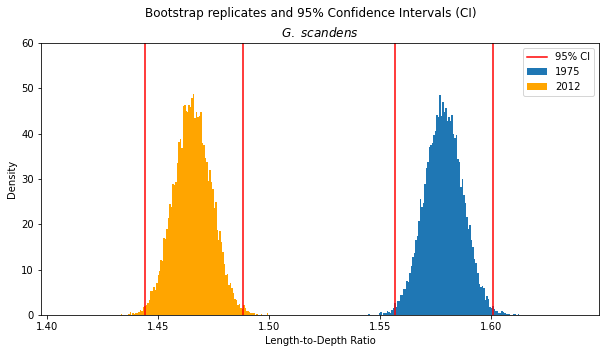

In [25]:
# Plotting the histogram to visualize distribution of bootstrap replicates
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(bs_replicates_1975, bins=100, density=True, label='1975');

ax.axvline(conf_int_1975[0], color='red', label='95% CI')
ax.axvline(conf_int_1975[1], color='red')

ax.hist(bs_replicates_2012, bins=100, density=True, label='2012', color='orange');

ax.axvline(conf_int_2012[0], color='red')
ax.axvline(conf_int_2012[1], color='red')


ax.set(ylabel='Density', xlabel='Length-to-Depth Ratio', ylim=(0, 60), title='$\itG.\ scandens$')
ax.legend()
ax.margins(0.2)
    
fig.suptitle('Bootstrap replicates and 95% Confidence Intervals (CI)');

### How different is the Length-to-Depth ratio?


In [26]:
# Print the results
print(f'1975: mean ratio = {mean_ratio_1975: 0.5f} | 95% CI = {conf_int_1975}')
print(f'2012: mean ratio = {mean_ratio_2012: 0.5f} | 95% CI = {conf_int_2012}')


1975: mean ratio =  1.57888 | 95% CI = [1.5570093  1.60118994]
2012: mean ratio =  1.46583 | 95% CI = [1.44433598 1.48835609]


[Text(0, 0.5, 'Length-to-Depth Ratio'), Text(0.5, 0, 'year')]

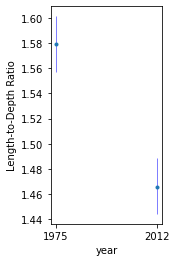

In [27]:
# plot data with DI
fig, ax = plt.subplots(figsize=(2, 4))

ax.plot(['1975', '2012'], [mean_ratio_1975, mean_ratio_2012], marker='.', ls='none')

ax.fill_between(
    ['1975'],
    [conf_int_1975[0]],
    [conf_int_1975[1]],
    color='b',
    alpha=0.5,
)
ax.fill_between(
    ['2012'],
    [conf_int_2012[0]],
    [conf_int_2012[1]],
    color='b',
    alpha=0.5,
)

ax.set(ylabel='Length-to-Depth Ratio', xlabel='year')

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not close to overlapping, so the beak shape changed during this time period.

## PART 3 - Measuring Heritability
___

What is driving the beak shapping in _G. scadens_. One of the possible explanations is the breeding with another species of finch birds: _G. fortis_. This putative breeding may cause the _G. scandens_ to inherit some features from the _G. fortis_.

### If this is true, then how strong parental traits (ie beak depth) are passed on to offspring?


### Data

The subdataset used in this part was provided by datacamp. 

In [28]:
url = 'https://raw.githubusercontent.com/joseferncruz/datascience_projects/master/notebooks/project01/data/finch_par_off.csv'

In [29]:
# Download dataset from github
finch_par_off = pd.read_csv(url, index_col=0)

finch_par_off.head()

,species,generation,bdepth
0,scandens,parental,8.3318
1,scandens,parental,8.4035
2,scandens,parental,8.5317
3,scandens,parental,8.7202
4,scandens,parental,8.7089



`bd_parent_scandens`, `bd_parent_fortis`: average beak depth (in mm) of two parents of the species _G. scandens_ and _G. fortis_, respectively;  
`bd_offspring_scandens`, `bd_offspring_fortis`: average beak depth of the offspring of the respective parents.


In [30]:
# Extract data into individual variables
bd_parent_scandens = finch_par_off[
    (finch_par_off['species']=='scandens') & (finch_par_off['generation']=='parental')
].bdepth.to_numpy()

bd_offspring_scandens = finch_par_off[
    (finch_par_off['species']=='scandens') & (finch_par_off['generation']=='offspring')
].bdepth.to_numpy()

bd_parent_fortis = finch_par_off[
    (finch_par_off['species']=='fortis') & (finch_par_off['generation']=='parental')
].bdepth.to_numpy()

bd_offspring_fortis = finch_par_off[
    (finch_par_off['species']=='fortis') & (finch_par_off['generation']=='offspring')
].bdepth.to_numpy()

### What is the relation between in beak depth in offspring vs parental?


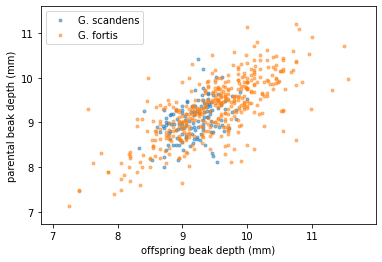

In [31]:
fig, ax = plt.subplots()

ax.plot(
    bd_parent_scandens,
    bd_offspring_scandens,
    marker='.',
    ls='none',
    alpha=0.5,
    label='G. scandens'
    
)

ax.plot(
    bd_parent_fortis,
    bd_offspring_fortis,
    marker='.',
    ls='none',
    alpha=0.5,
    label='G. fortis'
    
)

ax.set(
    ylabel='parental beak depth (mm)',
    xlabel='offspring beak depth (mm)',
)

ax.legend()
ax.margins(0.1)

It seems that in _G. fortis_ It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis. 

### Quantification of this correlation using the pearson correlation coefficient and bootstrapping to get the confidence interval.

In [32]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic test.
    
    Parameters
    ----------
    x : list, np.array
    y : list, np.array
    func : function
        The function used as test statistic
    size : int
        Number of bootstrap iterations
    
    
    Returns
    -------
    bs_replicates : np.array
        Array of length size with values of the func applied to the bootstrap replicates.
    
    """

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        
        # bootstrap indices
        bs_inds = np.random.choice(inds, size=len(inds))
        
        # Extract data
        bs_x, bs_y = x[inds], y[inds]
        
        # Calculate test statistic and append result
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

In [33]:
def pearson_r(data1, data2):
    """Returns the pearson's correlation coefficient.
    
    
    
    Parameters
    ----------
    data1 : list, np.array

    data2 : list, np.array
    
    Returns
    ------    
        Pearson's Correlation coefficient
    """
    
    return np.corrcoef(data1, data2)[0][1]

In [34]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens )
r_fortis =  pearson_r(bd_parent_fortis, bd_offspring_fortis )

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens,
                                       bd_offspring_scandens,
                                       pearson_r,
                                       size=1000
                                      )

bs_replicates_fortis = draw_bs_pairs(bd_offspring_fortis,
                                           bd_parent_fortis,
                                           pearson_r,
                                           size=1000
                                          )

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.41170636 0.41170636]
G. fortis: 0.7283412395518486 [0.72834124 0.72834124]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

### Measuring heritability

The Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability.

It makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone.

### Let's stimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

In [35]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples.
    
    Parameters
    ----------
    parents : list, np.array
    offspring : list, np.array
    
    
    Retuns
    ------
    float
        covariance(parents, offspring) / variance(parents)
    
    """
    
    covariance_matrix = np.cov(parents, offspring)
    
    return covariance_matrix[0][1] / covariance_matrix[0][0]

In [36]:
# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)        
replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('Heritability Measurements')
print(f'G. scandens: {heritability_scandens: 0.2f} | 95% CI: {conf_int_scandens}')
print(f'G. fortis: {heritability_fortis: 0.2f} | 95% CI: {conf_int_fortis}')


Heritability Measurements
G. scandens:  0.55 | 95% CI: [0.54853409 0.54853409]
G. fortis:  0.72 | 95% CI: [0.72290519 0.72290519]


It seems that features from G. fortis are strong passed into offspring when compared to G. scandens.  

The heritability of beak depth in G. scandens seems low (~0.55).  It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. Let's test this hypothesis using a __permutation test__.

In [37]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)

# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

print(f'The p-value associated is: {p}')

The p-value associated is: 0.0


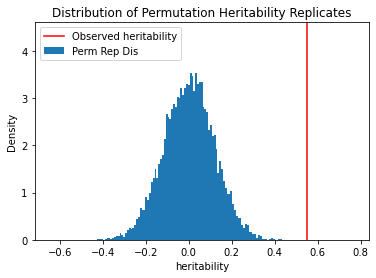

In [38]:
# plot the null distribution
fig, ax = plt.subplots()

ax.hist(perm_replicates, bins=100, density=True, label='Perm Rep Dis')
ax.axvline(heritability_scandens, color='red', label='Observed heritability')

ax.set(ylabel='Density', xlabel='heritability', title='Distribution of Permutation Heritability Replicates')

ax.legend(loc='upper left')
ax.margins(0.3)

plt.show()

### Conclusion of Part 3
---

The associated p-value is 0 means that in our simulation (10000 iterations) there was no value high enough to match the heritability observed.

This strongly suggests that beak depth is heritable in _G. scandens_ although in a lesser extent compared to _G. fortis_.